<a href="https://colab.research.google.com/github/veydantkatyal/VerifAI/blob/main/AI_text_detection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LOAD FILES**

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload `ai_text_detector.pkl` manually


Saving ai_text_detector.pkl to ai_text_detector.pkl


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload `ai_text_detector.pkl` manually


Saving sentence_transformer_model.zip to sentence_transformer_model.zip


In [ ]:
!unzip sentence_transformer_model.zip

Archive:  sentence_transformer_model.zip
   creating: sentence_transformer_model/
  inflating: sentence_transformer_model/README.md  
  inflating: sentence_transformer_model/tokenizer.json  
   creating: sentence_transformer_model/.ipynb_checkpoints/
   creating: sentence_transformer_model/1_Pooling/
  inflating: sentence_transformer_model/1_Pooling/config.json  
  inflating: sentence_transformer_model/modules.json  
  inflating: sentence_transformer_model/tokenizer_config.json  
  inflating: sentence_transformer_model/special_tokens_map.json  
  inflating: sentence_transformer_model/vocab.txt  
  inflating: sentence_transformer_model/config.json  
  inflating: sentence_transformer_model/config_sentence_transformers.json  
  inflating: sentence_transformer_model/sentence_bert_config.json  
   creating: sentence_transformer_model/2_Normalize/
  inflating: sentence_transformer_model/model.safetensors  


# **LOAD PRE-TRAINED MODELS**

In [ ]:
import numpy as np
import shap
import pickle
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

# Load Sentence Transformer model
embedder = SentenceTransformer("sentence_transformer_model")

# Load the Logistic Regression model
with open("ai_text_detector.pkl", "rb") as f:
    clf = pickle.load(f)

print("✅ Models Loaded Successfully!")


✅ Models Loaded Successfully!


# **RISK SCORE**


* Text is converted into numerical embeddings using embedder.encode().

* A Logistic Regression model is trained on AI vs. human-written text.

* The model predicts a probability score, showing how likely the text is AI-generated.

In [ ]:
def get_ai_risk_score(text):
    text_embedded = embedder.encode([text])
    ai_score = round(clf.predict_proba(text_embedded)[0][1] * 100, 2)
    return ai_score, text_embedded

# **GOOGLE FACT CHECK**

* Sends a request to Google's Fact Check API – The function queries Google's fact-checking tool with the given text to check for verified claims.

* Handles API responses and errors – It manages errors like invalid API keys (403) and other failures, ensuring smooth execution.

* Extracts and formats fact-check results – If verified claims are found, it collects details like the claim, source, credibility rating, and a link for more information.

In [ ]:
import requests

# ✅ Google Fact Check API Key
GOOGLE_FACT_CHECK_API_KEY = "GOOGLE_FACT_CHECK_API_KEY"

# ✅ Google Fact Check API Function
def fact_check_google(text):
    url = "https://factchecktools.googleapis.com/v1alpha1/claims:search"
    params = {
        "query": text,
        "key": GOOGLE_FACT_CHECK_API_KEY
    }

    response = requests.get(url, params=params)

    if response.status_code == 403:
        return "❌ Error 403: Invalid API Key.", []

    if response.status_code != 200:
        return f"❌ Error {response.status_code}: Unable to fetch data.", []

    data = response.json()

    if "claims" not in data or len(data["claims"]) == 0:
        return "⚠️ No verified fact-checks found.", []

    fact_check_results = []

    for claim in data["claims"]:
        claim_text = claim.get("text", "N/A")
        review = claim.get("claimReview", [{}])[0]

        publisher = review.get("publisher", {}).get("name", "Unknown Source")
        credibility = review.get("textualRating", "Not Rated")
        url = review.get("url", "#")

        fact_check_results.append(f"🔹 **Claim:** {claim_text}\n🔹 **Source:** {publisher}\n🔹 **Credibility:** {credibility}\n🔹 [More Info]({url})")

    return "✅ Fact-checking results found:", fact_check_results


# **HUGGINGFACE FOR EXPLANATION**

* Sends a request to Hugging Face API – The function uses an API call to the tiiuae/falcon-7b-instruct model to generate explanations.

* Constructs a structured prompt – It formats the text, AI risk score, and classification into a detailed prompt for better responses.

* Handles API response and returns explanation – If successful, it extracts the generated explanation; otherwise, it returns an error message.

In [ ]:
import requests

# ✅ Hugging Face API Key
HUGGINGFACE_API_KEY = "HUGGINGFACE_API_KEY"
HF_MODEL = "tiiuae/falcon-7b-instruct"

# ✅ Function to Generate Structured Explanation
def generate_personalized_explanation(text, ai_score):
    headers = {
        "Authorization": f"Bearer {HUGGINGFACE_API_KEY}",
        "Content-Type": "application/json"
    }

    prompt = f"""
    Given the text: "{text}"

    - AI Risk Score: {ai_score}%
    - Classification: {"Fully Human-Written" if ai_score < 35 else "Mix of AI & Human" if 35 <= ai_score <= 60 else "Mostly AI-Generated" if ai_score < 85 else "Strongly AI-Generated"}

    Now explain the AI classification in **three distinct sentences**:
    1️⃣ **Why the AI classified it this way?**
    2️⃣ **How does AI-generated text differ from human-written text?**
    3️⃣ **Provide a simple real-world analogy.**

    Ensure the response is short, unique, and free from repetition.
    """

    data = {"inputs": prompt, "parameters": {"max_new_tokens": 150}}
    response = requests.post(f"https://api-inference.huggingface.co/models/{HF_MODEL}", headers=headers, json=data)

    if response.status_code == 200:
        return response.json()[0]["generated_text"]
    else:
        return "❌ Error: Could not generate explanation."


In [ ]:
!pip install lime

# **VISUALIZATIONS**

* AI Risk Scoring & XAI Analysis – Converts text into embeddings, predicts AI probability using logistic regression, and explains decisions with SHAP & LIME.

* Fact-Checking & Explanation – Integrates Google Fact Check API to verify claims and generates a personalized explanation for classification.

* Visual Interpretability – Uses bar charts, SHAP & LIME plots, and heatmaps to clearly show AI vs. human-like features in the text.

In [ ]:
import shap
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Store embeddings for LIME training
embedding_dataset = []

# ✅ AI Text Detection + SHAP + LIME + Fact-Checking + Explanation
def explain_risk_score_with_visuals(text):
    global embedding_dataset

    # Convert text to embeddings
    text_embedded = embedder.encode([text])
    embedding_dataset.append(text_embedded[0])

    # ✅ Get AI Risk Score
    ai_score, _ = get_ai_risk_score(text)

    # ✅ SHAP Explanation
    explainer_shap = shap.Explainer(clf, np.array(embedding_dataset))
    shap_values = explainer_shap(text_embedded)

    # Get feature importances
    shap_values_mean = np.abs(shap_values.values).mean(axis=0)

    # ✅ LIME Explanation
    lime_exp = None
    if len(embedding_dataset) > 1:
        explainer_lime = lime.lime_tabular.LimeTabularExplainer(
            training_data=np.array(embedding_dataset),
            mode="classification"
        )
        lime_exp = explainer_lime.explain_instance(text_embedded[0], clf.predict_proba)

    # ✅ Fact-Checking & Human Explanation
    fact_check_status, fact_check_results = fact_check_google(text)
    explanation = generate_personalized_explanation(text, ai_score)

    # ✅ AI Risk Score Visualization (Bar Chart)
    plt.figure(figsize=(6, 3))
    sns.barplot(x=[100 - ai_score, ai_score], y=["Human", "AI"], palette=["blue", "red"])
    plt.xlim(0, 100)
    plt.xlabel("Probability (%)")
    plt.title(f"AI Risk Score: {ai_score}%")
    plt.show()

    # ✅ SHAP Summary Plot
    shap.summary_plot(shap_values, text_embedded, show=True)

    # ✅ SHAP Feature Importance Bar Plot
    plt.figure(figsize=(7, 4))
    sns.barplot(x=shap_values_mean, y=np.arange(len(shap_values_mean)), palette="coolwarm")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Index")
    plt.title(f"SHAP Feature Impact - AI Risk Score {ai_score}%")
    plt.show()

    # ✅ LIME Explanation Plot
    if lime_exp:
        lime_exp.as_pyplot_figure()
        plt.title(f"LIME Explanation (AI Risk Score: {ai_score}%)")
        plt.show()

    # ✅ Feature Heatmap for AI/Human Influence
    plt.figure(figsize=(10, 5))
    heatmap_values = np.abs(shap_values.values).mean(axis=0).reshape(1, -1)
    sns.heatmap(heatmap_values, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title(f"Feature Heatmap - AI Risk Score {ai_score}%")
    plt.xlabel("Feature Dimensions (Embeddings)")
    plt.ylabel("Feature Importance")
    plt.show()

    # ✅ Print Results
    print(f"\n🔹 **Input:** {text}")
    print(f"🛑 **AI Risk Score:** {ai_score}%")
    print("\n📌 **Explanation:**")
    print(explanation)

    print(f"\n🔎 **Fact-Checking Results:** {fact_check_status}")
    for result in fact_check_results:
        print(result)

    return ai_score

# **SAMPLE TESTING**

<ipython-input-39-538beb0c8eca>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[100 - ai_score, ai_score], y=["Human", "AI"], palette=["blue", "red"])


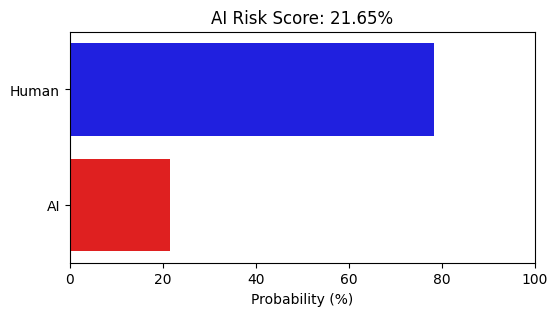

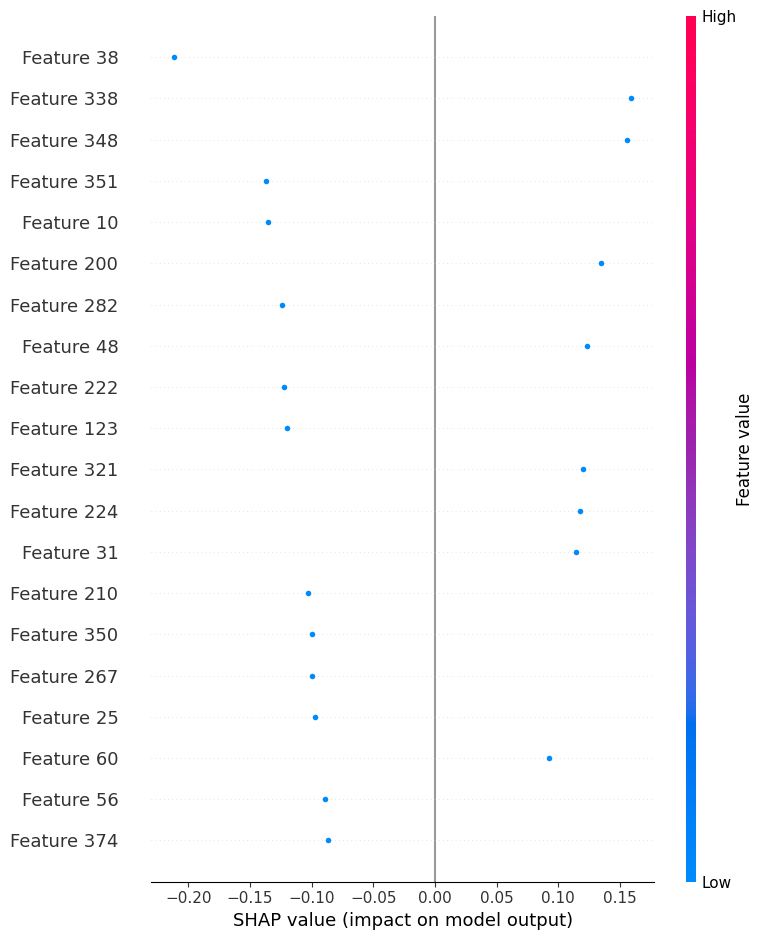

<ipython-input-39-538beb0c8eca>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=shap_values_mean, y=np.arange(len(shap_values_mean)), palette="coolwarm")


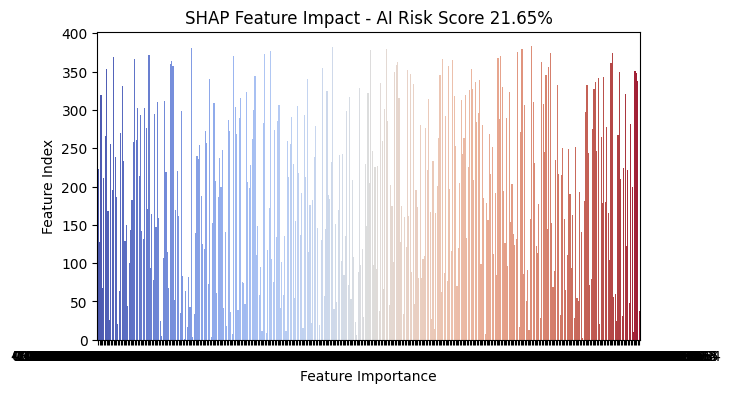

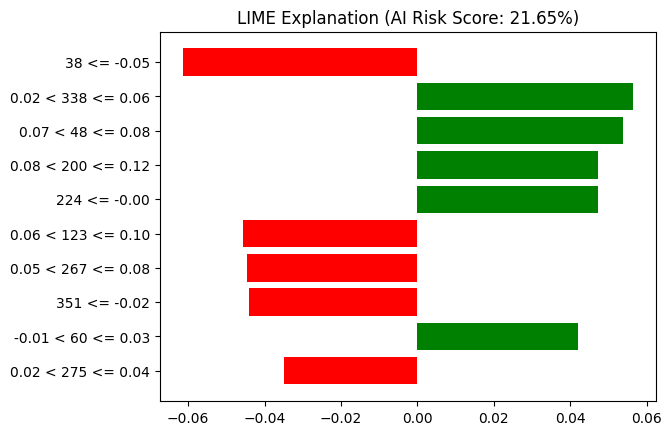

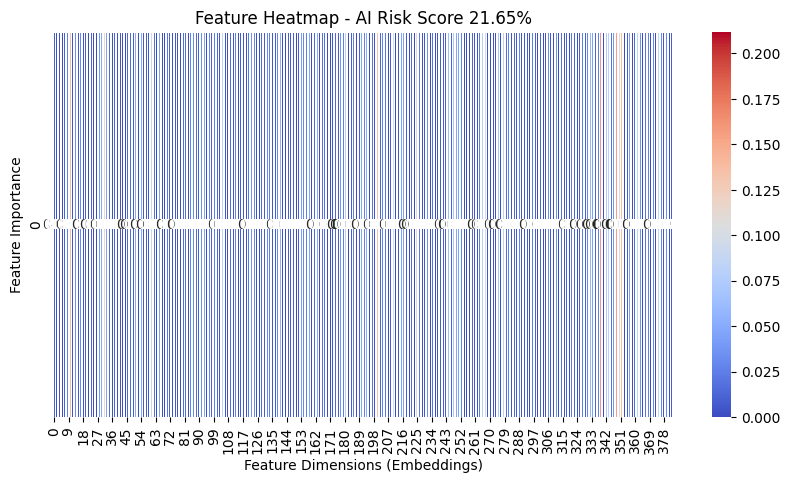


🔹 **Input:** stop crying
🛑 **AI Risk Score:** 21.65%

📌 **Explanation:**

    Given the text: "stop crying"

    - AI Risk Score: 21.65%
    - Classification: Fully Human-Written

    Now explain the AI classification in **three distinct sentences**:
    1️⃣ **Why the AI classified it this way?**  
    2️⃣ **How does AI-generated text differ from human-written text?**  
    3️⃣ **Provide a simple real-world analogy.**  

    Ensure the response is short, unique, and free from repetition.
    - AI Risk Score: 21.65%
    - Classification: Fully Human-Written

The text "stop crying" is classified as **Fully Human-Written** because it is written in natural language and does not contain any machine-generated text. This is in contrast to the AI-generated text, which is classified as **Why the AI classified it this way?** because it is generated by a machine and contains a specific set of words that are not found in natural language.

🔎 **Fact-Checking Results:** ✅ Fact-checking results foun

21.65

In [ ]:
sample_text = "stop crying"
explain_risk_score_with_visuals(sample_text)


# **SAVE & LOAD MODELS**

In [ ]:
import pickle

# Save the updated Logistic Regression model
with open("ai_text_detector_final.pkl", "wb") as f:
    pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)  # Highest protocol for efficiency

print("✅ Updated AI Text Detector Model Saved Successfully as ai_text_detector_final.pkl!")

import os
from sentence_transformers import SentenceTransformer

# Save Sentence Transformer model only if not already saved
if not os.path.exists("sentence_transformer_model_final"):
    embedder.save("sentence_transformer_model_final")

print("✅ Updated Sentence Transformer Model Saved Successfully as sentence_transformer_model_final!")


✅ Updated AI Text Detector Model Saved Successfully as ai_text_detector_final.pkl!
✅ Updated Sentence Transformer Model Saved Successfully as sentence_transformer_model_final!


In [ ]:
!zip -r sentence_transformer_model_final.zip sentence_transformer_model_final


  adding: sentence_transformer_model_final/ (stored 0%)
  adding: sentence_transformer_model_final/README.md (deflated 64%)
  adding: sentence_transformer_model_final/tokenizer.json (deflated 71%)
  adding: sentence_transformer_model_final/1_Pooling/ (stored 0%)
  adding: sentence_transformer_model_final/1_Pooling/config.json (deflated 57%)
  adding: sentence_transformer_model_final/modules.json (deflated 62%)
  adding: sentence_transformer_model_final/tokenizer_config.json (deflated 73%)
  adding: sentence_transformer_model_final/special_tokens_map.json (deflated 80%)
  adding: sentence_transformer_model_final/vocab.txt (deflated 53%)
  adding: sentence_transformer_model_final/config.json (deflated 48%)
  adding: sentence_transformer_model_final/config_sentence_transformers.json (deflated 34%)
  adding: sentence_transformer_model_final/sentence_bert_config.json (deflated 4%)
  adding: sentence_transformer_model_final/2_Normalize/ (stored 0%)
  adding: sentence_transformer_model_final/